In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

# https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [2]:
%%time
############################
######## LIBRAIRIES ########
############################
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johasen
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import sklearn.preprocessing
from statsmodels.tsa.stattools import adfuller
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import numpy as np
%matplotlib inline
plt.style.use('seaborn')


##############################################
######## INITIALISATION DES VARIABLES ########
##############################################

step = 0
nb_jour = 7
diloug = nb_jour * 288

os,cs,ol,cl = 0,0,0,0

mise = 100000
profit_long = 0
profit_short = 0
profit = 0
nbre_trade = 0
nbre_trade_long = 0
nbre_trade_short = 0
pnls = 0
pnll = 0

buy1 = 0
buy2 = 0
buy3 = 0
sell1 = 0
sell2 = 0
sell3 = 0
nbposl= 0
nbposs = 0

mark = 0
navette = 0
break_it = 0

stop = 0
full_stop = 1

OS = []
OL = []
CL = []
CS = []
SELL1 = []
SELL2 = []
SELL3 = []
BUY1 = []
BUY2 = []
BUY3 = []
NBPOSS = []
NBPOSL = []
TIME = []
TIME_FRAME = []
SCORE = []
CSTE = []
DYNS = []

name = ''
############################
######## FONCTIONS ########
###########################

def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()

    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    if p_value <= 0.05:
        stop = 0
    else:
        stop = 1
    return(stop)

def skewness(df):
    if skew < -0.1 or skew > 0.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def kurtos(df):
    if kurtosis > -3.1 or kurtosis < 3.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor(df):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor_diff(diff):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        p = 1
    else:
        stop = 1
    return()

def test_stationarity(timeseries,lag):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

def test_adf(df):
    X = df['Close'].values
    result_adf = adfuller(X)
    
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        stop = 1
    else:
        stop = 0
        
    X = diff[1:].values
    result_adf = adfuller(X)
    
    if result_adf[1] >= 0.05 :
        stop = 1

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        stop = 1

    else:
        stop = 0
    return(stop)

def isname(pair):
    global name
    if pair.equals(eurusd):
        name = 'EUR/USD'
    elif pair.equals(audusd):
        name = 'AUD/USD'
    elif pair.equals(chfusd):
        name = 'CHF/USD'
    elif pair.equals(gbpusd):
        name = 'GBP/USD'
    elif pair.equals(jpyusd):
        name = 'JPY/USD'
    
    return(name)

def revname(name):
    if name == 'EUR/USD':
        pair = eurusd
    elif name == 'AUD/USD':
        pair = audusd
    elif name == 'CHF/USD':
        pair = chfusd
    elif name == 'GBP/USD':
        pair = gbpusd
    elif name == 'JPY/USD':
        pair = jpyusd
        
    return(pair)

def transform():
    df = pd.DataFrame()
    inv = 'NON'
    dfname = input('Entrez le nom du fichier à transformer (sans le .csv)')
    print('Parsing des dates. Cela peut prendre quelques minutes')
    df = pd.read_csv(dfname+'.csv',parse_dates=['Local time'])
    inv = input('Doit-on inverser les devises? (NON - OUI)')
    if inv == 'OUI' or inv == 'oui' or inv == 'o' or inv =='O':
        print('inversion des devises')
        df['Open'] = 1 / df['Open']
        df['High'] = 1 / df['High']
        df['Low'] = 1 / df['Low']
        df['Close'] = 1 / df['Close']
        df.to_csv(dfname+'_transformed.csv')
    else:
        df.to_csv(dfname+'_transformed.csv')
        
    print('Done pour ',dfname+'.csv')
    return()

def train(base_eurusd,base_audusd,base_chfusd,base_gbpusd,base_jpyusd,TIME_FRAME):
    global pair,eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,kmo_all,chi_square_value,p_value,ev,v,jh_results,v1,v2,skew,kurtosis,df,full_stop,residu,S,\
    coef,cste,break_it,debut,fin,split,navette,step,mark
    
    for step in range(navette,len(base_audusd)):
        print(Fore.MAGENTA,'')
        print('Step : ',step, '|||| TIME_FRAME[step] <---> debut :',TIME_FRAME[step],'TIME_FRAME[step+diloug - 576] : ',TIME_FRAME[step+diloug-576],\
        'TIME_FRAME[step+diloug] <----> split', TIME_FRAME[step+diloug])
        print(Style.RESET_ALL,'')
        debut = TIME_FRAME[step]
        split = TIME_FRAME[step+diloug]
        fin = TIME_FRAME[-1]#step+diloug]

        eurusd = base_eurusd[(base_eurusd['Local time'] >= debut)&(base_eurusd['Local time'] <= split)]
        audusd = base_audusd[(base_audusd['Local time'] >= debut)&(base_audusd['Local time'] <= split)]
        chfusd = base_chfusd[(base_chfusd['Local time'] >= debut)&(base_chfusd['Local time'] <= split)]
        gbpusd = base_gbpusd[(base_gbpusd['Local time'] >= debut)&(base_gbpusd['Local time'] <= split)]
        jpyusd = base_jpyusd[(base_jpyusd['Local time'] >= debut)&(base_jpyusd['Local time'] <= split)]


        PAIR = [eurusd,audusd,chfusd,gbpusd,jpyusd]

        for pair in PAIR:

            name = isname(pair)

            model = sm.OLS(pair['Close'],pair.index)
            results = model.fit()
            residuals = results.resid
            summary = results.summary()

            jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

            jarque_berra(pair)
            skewness(pair)
            kurtos(pair)
            autocor(pair)
        df = pd.DataFrame()
        for pair in PAIR:
            name = isname(pair)
            df[name] = list(pair['Close'])
        df.corr().style.background_gradient(cmap='coolwarm')

        INTEGRE = []
        for col in range(1,len(df.corr())):
            for ind in range(col):
                if df.corr().iloc[ind,col] > 0.5 and df.corr().iloc[ind,col] != 1:
                    INTEGRE.append((df.corr().index[ind],df.corr().columns[col]))


        INTEGRE  = list(set(INTEGRE))

        kmo_all,kmo_model=calculate_kmo(df)

        for loop,pair in enumerate(PAIR):
            name = isname(pair)
            if kmo_all[loop] >= 0.6:
                print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquat',Style.RESET_ALL)
            else:
                print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)
                if name == 'EUR/USD':
                    print('Problème sur la base principale. On procède à un saut incrémentiel')
                    break_it = 1

        chi_square_value,p_value=calculate_bartlett_sphericity(df)
        if p_value < 0.05:
            stop = 0
        else:
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 311\n\n\n',Style.RESET_ALL)

        fa = FactorAnalyzer(rotation=None)
        fa.fit(df)

        ev, v = fa.get_eigenvalues()

        PRINCIPAL_COMPOSANT = []
        for loop,pair in enumerate(PAIR):
            name = isname(pair)
            if ev[loop] >= 1:
                PRINCIPAL_COMPOSANT.append((name,ev[loop]))

        jh_results = johasen(df,0,1)
        v1 = jh_results.evec[:, 0]
        v2 = jh_results.evec[:, 1]
        if jh_results.eig[0] <= 0.05:
            stop = 0
        else:
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 333\n\n\n',Style.RESET_ALL)
        
        X = df.iloc[:,1:]
        y = df.iloc[:,0]
        reg = LinearRegression().fit(X, y)
        score = reg.score(X, y) *100
        coef = reg.coef_
        cste = reg.intercept_
        CSTE.append(cste)

        if score > 70:
            stop = 0
            loop = -1
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 432\n\n\n',Style.RESET_ALL)

        elif score > 50:
            
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 448\n\n\n',Style.RESET_ALL)

        else:
            stop = 1
            loop = 0
            for pair in PAIR:
                name = isname(pair)
                if name == 'EUR/USD':
                    continue
                loop += 1
                try:
                    print(name,' : ',coef[loop])
                except:
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 465\n\n\n',Style.RESET_ALL)
                        continue

        combo = coef[0] * df['AUD/USD'] + coef[1] * df['CHF/USD'] + coef[2] * df['GBP/USD'] + coef[3] * df['JPY/USD'] + cste

        ########
        ### RESIDUS
        ########
        residu = df['EUR/USD']-combo
        S = (residu - residu.mean())/residu.std()

        ####
        ## ANALYSE DES RESIDUS
        ###

        jarque_berra(residu)
        skewness(residu)
        kurtos(residu)
        residu_autocor = pd.DataFrame()
        residu_autocor['Close'] = residu.iloc[:]
        autocor(residu_autocor)

        model = sm.OLS(residu,residu.index)
        results = model.fit()
        residuals = results.resid
        summary = results.summary()
        name = 'Analyse des Résidus'
        jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

        dfoutput =  test_stationarity(residu,lag = 1)
        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
            stop = 0
        else:
            print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 501\n\n\n',Style.RESET_ALL)

        #######
        ### RETOUR A LA MOYENNE
        #######
        dfoutput =  test_stationarity(residu,lag = 0)

        if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
            print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 0
        else:
            print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)
            stop = 1
            if nbposs == 0 and nbposl == 0 : 
                continue
                print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 516\n\n\n',Style.RESET_ALL)


        chi_square_value,p_value=calculate_bartlett_sphericity(df)
        if p_value < 0.05:
            #print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
            pass
        else:
            #print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )
            pass

        fa = FactorAnalyzer(rotation=None)
        fa.fit(df)

        ev, v = fa.get_eigenvalues()



        pca = PCA(n_components=2)
        pca.fit(df)

        x_pca = pca.transform(df)
        x_pca.shape


        for loop,pair in enumerate(PAIR):
            name = isname(pair)

        jh_results = johasen(df,0,1)

        v1 = jh_results.evec[:, 0]
        v2 = jh_results.evec[:, 1]

        if jh_results.eig[0] <= 0.05:
            #print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
            pass
        else:
            #print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)
            pass
        print('\nTEST DU FULL STOP - et stop à ',stop,' - ','\n')
        if stop == 0 and break_it != 1:
            print('\nFull Stop à 0\n')
            full_stop = 0
            print(Back.LIGHTBLUE_EX,Fore.YELLOW,' P E R I O D E    D E    T R A I N    T E R M I N E E ',Style.RESET_ALL)
            print('\n\n')
            break
        else:
            print('\nFull Stop à 1\n')
            full_stop = 1
            break_it = 0
    return(eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,split,step,S)


def dyns():
    
    global lim_s1,lim_s2,lim_l1,lim_l2,lim_cs,lim_cl,amplitude,dyn_S

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)
    print('\nLe split a été effectué le ',split,'\n')

    print('\n\nTAILLES DES POSITIONS :')
    try:
        print('EUR/USD : ', mise)
    except:
        print('EUR/USD => NON VALIDE')

    try:
        print('AUD/USD : ',coef[0] * mise)
    except:
        print('AUD/USD => NON VALIDE')
    try:
        print('CHF/USD : ',coef[1] * mise)
    except:
        print('CHF/USD => NON VALIDE')
    try:
        print('GBP/USD : ',coef[2] * mise)
    except:
        print('GBP/USD => NON VALIDE')
    try:
        print('JPY/USD : ',coef[3] * mise)
    except:
        print('JPY/USD => NON VALIDE')
    print('\n')

    print('Le Score max est : ',max(S),' et le Score min : ',min(S))
   
    df = pd.DataFrame(index=base_audusd['Local time'])
    df['EUR/USD'] = list(base_eurusd['Close'])
    df['AUD/USD'] = list(base_audusd['Close'])
    df['CHF/USD'] = list(base_chfusd['Close'])
    df['GBP/USD'] = list(base_gbpusd['Close'])
    df['JPY/USD'] = list(base_jpyusd['Close'])

    # for mark in range(base_audusd[base_audusd['Local time'] == split].index[0],base_audusd[base_audusd['Local time'] == fin].index[0]):
    dynamic_df = df[df.index <= base_audusd.iloc[mark]['Local time']]
    print(Fore.MAGENTA,'')
    print('Indice : ',mark,base_audusd.iloc[mark]['Local time'])
    print(Style.RESET_ALL,'')
    print(Back.RED,Fore.BLACK,' A C T I O N ',Style.RESET_ALL)

    #dynamic_df = big_df[big_df.index <= mark]
    dynamic_combo = coef[0] * dynamic_df['AUD/USD'] + coef[1] * dynamic_df['CHF/USD'] + coef[2] * dynamic_df['GBP/USD'] \
    + coef[3] * dynamic_df['JPY/USD'] + cste

    dynamic_residu = dynamic_df['EUR/USD'] - dynamic_combo
    dyn_S = (dynamic_residu - dynamic_residu.mean())/dynamic_residu.std()
    dyn_S = dyn_S[-1]
    #dyn_S = sklearn.preprocessing.scale(dyn_S)[-1]
    DYNS.append(dyn_S)
    
    amplitude = round(max(DYNS)) - round(min(DYNS))
    print("L'amplitude détectée est de ",amplitude)

    lim_s1 = np.array(DYNS).mean()+1*np.array(DYNS).std()
    lim_s2 = np.array(DYNS).mean()+1.5*np.array(DYNS).std()
    print('Voici les 4 limites de short',lim_s1,lim_s2,lim_s2+lim_s1)
    lim_l1 = np.array(DYNS).mean()-1.5*np.array(DYNS).std()
    lim_l2 = np.array(DYNS).mean()-1*np.array(DYNS).std()
    print('Voici les 4 limites de short',lim_l1,lim_l2,lim_l2+lim_l1)
    lim_cs = np.array(DYNS).mean()-0.5*np.array(DYNS).std()
    print('Voici la limite de close short',lim_cs)
    lim_cl = np.array(DYNS).mean()+0.5*np.array(DYNS).std()
    print('Voici la limite de close long',lim_cl)

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)
    return()

def test():
    global os,ol,cs,cl,buy1,buy2,buy3,sell1,sell2,sell3,nbposs,nbposl,nbpos,nbre_trade,nbre_trade_long,nbre_trade_short,profit,profit_long,profit_short,\
   pnll,pnls,eol,auol,chol,gbol,jpol,eos,auos,chos,gbos,jpos,pnles,pnlaus,pnlchs,pnlgbs,pnljps,pnlel,pnlaul,pnlchl,pnlgbl,pnljpl
    print('\n\n')
    print(Back.YELLOW,Fore.BLACK,'./\_-°oO-_____T E S T_____-Oo°-_./\\',Style.RESET_ALL)

    df = pd.DataFrame(index=base_audusd['Local time'])
    df['EUR/USD'] = list(base_eurusd['Close'])
    df['AUD/USD'] = list(base_audusd['Close'])
    df['CHF/USD'] = list(base_chfusd['Close'])
    df['GBP/USD'] = list(base_gbpusd['Close'])
    df['JPY/USD'] = list(base_jpyusd['Close'])

    if dyn_S > lim_s1 and dyn_S < lim_s2 and os == 0 and ol == 0 and sell1 == 0 and sell2 == 0 and sell3 == 0:
        #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
        os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 1
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0

        eos = mise * df.iloc[mark]['EUR/USD'] - cste
        auos = -  mise * coef[0] * df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * df.iloc[mark]['CHF/USD']
        gbos = - mise * coef[2] * df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * df.iloc[mark]['JPY/USD']


        print('\n\nDate : ',df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])  

    elif dyn_S > lim_s2 and dyn_S < (lim_s1+lim_s2) and ol == 0 and sell2 == 0 and sell3 == 0:
        #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
        os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 1
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0

        eos = mise * df.iloc[mark]['EUR/USD'] - cste
        auos = -  mise * coef[0] * df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * df.iloc[mark]['CHF/USD']
        gbos = - mise * coef[2] * df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * df.iloc[mark]['JPY/USD']


        print('\n\nDate : ',df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD']) 

    elif dyn_S > (lim_s1+lim_s2) and dyn_S < amplitude and ol == 0 and sell3 == 0:
        #_os = scatter =  plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='o',label='Open Short')
        os = 1
        ol = 0
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 1
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 1
        nbposl = 0
        
        eos = mise * df.iloc[mark]['EUR/USD'] - cste
        auos = -  mise * coef[0] * df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * df.iloc[mark]['CHF/USD']
        gbos = - mise * coef[2] * df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * df.iloc[mark]['JPY/USD']


        print('\n\nDate : ',df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])  

    elif dyn_S < lim_cs and os == 1 :
        #_cs = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='x',label='Close Short : ')
        nbpos = sell1+sell2+sell3
        os = 0
        ol = 0
        cl = 0
        cs = 1
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 0


        print('\n\nDate : ',df.index[mark])
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD']) 


        ecs = - mise * nbpos * df.iloc[mark]['EUR/USD'] + cste
        aucs = mise * nbpos * coef[0] * df.iloc[mark]['AUD/USD']
        chcs = mise * nbpos * coef[1] * df.iloc[mark]['CHF/USD']
        gbcs = mise * nbpos * coef[2] * df.iloc[mark]['GBP/USD']
        jpcs = mise * nbpos * coef[3] * df.iloc[mark]['JPY/USD']

        pnles = eos + ecs
        pnlaus = auos + aucs
        pnlchs = (chos + chcs) 
        pnlgbs = gbos + gbcs
        pnljps = (jpos + jpcs) 
        pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
        pnls = pnles + pnlcombos

        nbre_trade += 1
        nbre_trade_short +=1

        profit = profit + pnls
        

        print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
                '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)

    elif dyn_S > 40 and os == 1:
        #_cs = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='r',marker='x',label='Close Short : ')
        os = 0
        ol = 0
        cl = 0
        cs = 1
        nbpos = sell1+sell2+sell3
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 0


        print('\n\nDate : ',df.index[mark])
        print(Fore.RED,'ACTION CLOSE SHORT',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD']) 


        ecs = - mise * nbpos * df.iloc[mark]['EUR/USD'] + cste
        aucs = mise * nbpos * coef[0] * df.iloc[mark]['AUD/USD']
        chcs = mise * nbpos * coef[1] * df.iloc[mark]['CHF/USD']
        gbcs = mise * nbpos * coef[2] * df.iloc[mark]['GBP/USD']
        jpcs = mise * nbpos * coef[3] * df.iloc[mark]['JPY/USD']

        pnles = eos + ecs
        pnlaus = auos + aucs
        pnlchs = (chos + chcs) 
        pnlgbs = gbos + gbcs
        pnljps = (jpos + jpcs) 
        pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
        pnls = pnles + pnlcombos

        nbre_trade += 1
        nbre_trade_short +=1

        profit = profit + pnls

        print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
                '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)

    elif dyn_S < lim_l1 and dyn_S > lim_l2 and os == 0 and ol == 0 and buy1 == 0 and buy2 == 0 and buy3 == 0:
        #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
        os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 1
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 1
        print('\n\nDate : ',df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        eol = - mise * df.iloc[mark]['EUR/USD'] + cste
        auol = mise * coef[0] * df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * df.iloc[mark]['CHF/USD']
        gbol = mise * coef[2] * df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * df.iloc[mark]['JPY/USD']

    elif dyn_S < lim_l2 and dyn_S > (lim_l1+lim_l2) and os == 0 and buy2 == 0 and buy3 == 0:
        #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
        os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 1
        buy3 = 0
        nbposs = 0
        nbposl = 1

        print('\n\nDate : ',df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        eol = - mise * df.iloc[mark]['EUR/USD']
        auol = mise * coef[0] * df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * df.iloc[mark]['CHF/USD']
        gbol = mise * coef[2] * df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * df.iloc[mark]['JPY/USD']


    elif dyn_S < (lim_l1+lim_l2) and dyn_S > -amplitude and os == 0 and buy3 == 0:
        #_ol = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='o',label='Open Long')
        os = 0
        ol = 1
        cl = 0
        cs = 0
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 1
        nbposs = 0
        nbposl = 1
        print('\n\nDate : ',df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],'\nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        eol = - mise * df.iloc[mark]['EUR/USD'] + cste
        auol = mise * coef[0] * df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * df.iloc[mark]['CHF/USD']
        gbol = mise * coef[2] * df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * df.iloc[mark]['JPY/USD']


    elif dyn_S > lim_cl and ol == 1 :
        #_cl = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='x',label='Close Long')
        os = 0
        ol = 0
        cl = 1
        cs = 0
        nbpos = buy1+buy2+buy3
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 0


        print('\n\nDate : ',df.index[mark])
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Natural Close',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        ecl = mise * nbpos * df.iloc[mark]['EUR/USD']
        aucl = -  mise * nbpos * coef[0] * df.iloc[mark]['AUD/USD']
        chcl = - mise * nbpos * coef[1] * df.iloc[mark]['CHF/USD']
        gbcl = - mise * nbpos * coef[2] * df.iloc[mark]['GBP/USD']
        jpcl = - mise * nbpos * coef[3] * df.iloc[mark]['JPY/USD']

        pnlel = eol + ecl
        pnlaul = auol + aucl
        pnlchl = (chol + chcl) 
        pnlgbl = gbol + gbcl
        pnljpl = (jpol + jpcl) 
        pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
        pnll = pnlel + pnlcombol

        nbre_trade += 1
        nbre_trade_long +=1

        profit = profit + pnll

        print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
                '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)

        print('\n\nProfit en Long :',pnll)
        print('Profit en Short : ',pnls)


    elif dyn_S < -400 and ol == 1:
        #_cl = scatter = plt.scatter(x=mark,y=bt_S.iloc[mark],c='g',marker='x',label='Close Long')
        os = 0
        ol = 0
        cl = 1
        cs = 0
        nbpos = buy1+buy2+buy3
        sell1 = 0
        sell2 = 0
        sell3 = 0
        buy1 = 0
        buy2 = 0
        buy3 = 0
        nbposs = 0
        nbposl = 0


        print('\n\nDate : ',df.index[mark])
        print(Fore.RED,'ACTION CLOSE LONG',Fore.MAGENTA,'Stop Loss',Style.RESET_ALL,\
                '- \nclose EUR/USA ',df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',df.iloc[mark]['AUD/USD'],\
                '\nClose CHF/USD : ',df.iloc[mark]['CHF/USD'],' \nClose GBP/USD : ', df.iloc[mark]['GBP/USD'],\
                '\nClose JPY/USD : ',df.iloc[mark]['JPY/USD'])

        ecl = mise * nbposl * df.iloc[mark]['EUR/USD'] - cste
        aucl = -  mise * nbpos * coef[0] * df.iloc[mark]['AUD/USD']
        chcl = - mise * nbpos * coef[1] * df.iloc[mark]['CHF/USD']
        gbcl = - mise * nbpos * coef[2] * df.iloc[mark]['GBP/USD']
        jpcl = - mise * nbpos * coef[3] * df.iloc[mark]['JPY/USD']

        pnlel = eol + ecl
        pnlaul = auol + aucl
        pnlchl = (chol + chcl) 
        pnlgbl = gbol + gbcl
        pnljpl = (jpol + jpcl) 
        pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
        pnll = pnlel + pnlcombol

        nbre_trade += 1
        nbre_trade_long += 1

        profit = profit + pnll
        

        print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
                '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)

        print('\n\nProfit en Long :',pnll)
        print('Profit en Short : ',pnls)
    
    else:
        print('\n NONE ===> ITERATION SUIVANTE\n')
        OS.append(os)
        OL.append(ol)
        CL.append(cl)
        CS.append(cs)
        SELL1.append(sell1)
        SELL2.append(sell2)
        SELL3.append(sell3)
        BUY1.append(buy1)
        BUY2.append(buy2)
        BUY3.append(buy3)
        NBPOSS.append(nbposs)
        NBPOSL.append(nbposl)
        TIME.append(str(df.index[-1]))
        SCORE.append(S.iloc[-1])     

    OS.append(os)
    OL.append(ol)
    CL.append(cl)
    CS.append(cs)
    SELL1.append(sell1)
    SELL2.append(sell2)
    SELL3.append(sell3)
    BUY1.append(buy1)
    BUY2.append(buy2)
    BUY3.append(buy3)
    NBPOSS.append(nbposs)
    NBPOSL.append(nbposl)
    TIME.append(str(df.index[-1]))
    SCORE.append(S.iloc[-1])

    #except:
        #print(Back.WHITE,Fore.CYAN,'/!\  P R O B L E M  /!\\',Style.RESET_ALL)
        #continue
    return()

def resultats():
    plt.figure(figsize=(22,5))
    _plot = plt.plot(DYNS,label = 'Score')
    plt.axhline(y=np.array(DYNS).mean()+1*np.array(DYNS).std(),c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal')
    plt.axhline(y=np.array(DYNS).mean()+0.5*np.array(DYNS).std(),c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
    plt.axhline(y=np.array(DYNS).mean()-0.5*np.array(DYNS).std(),c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
    plt.axhline(y=np.array(DYNS).mean()-1*np.array(DYNS).std(),c='green',alpha=0.4,linestyle='--',label='Open Buy signal')
    plt.axhline(y=sum(DYNS)/len(DYNS),c='magenta',alpha=0.4,linestyle=':',label='Zéro')
    plt.legend()
    plt.title('Plot Signaux Achat / Vente sur le Score')
    try:
        plt.legend((OS,CS,OL,CL),('Open Short','Close Short','Open Long','Close Long'),scatterpoints=1 )
    except:
        pass

    print(Fore.YELLOW,'------------------------------------------------------------------------')
    print(' --------------------------------RESULTATS-------------------------------')
    print(' ------------------------------------------------------------------------',Style.RESET_ALL)
    if profit < 0:
        print('Le profit généré en $',Fore.RED,round(profit,2),Style.RESET_ALL)


    if profit > 0:
        print('Le profit généré en $',Fore.GREEN,round(profit,2),Style.RESET_ALL)

    print('Nombre de trades long : ',nbre_trade_long)
    print('Nombre de trades short : ',nbre_trade_short)
    print('Nombre total de trades : ',nbre_trade)
    return()



############################
########### MAIN ###########
############################

base_eurusd = pd.read_csv('EURUSD.csv')
try:
    base_eurusd = base_eurusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_eurusd['Local time'] = pd.to_datetime(base_eurusd['Local time'])

base_audusd = pd.read_csv('AUDUSD.csv')

try:
    base_audusd = base_audusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_audusd['Local time'] = pd.to_datetime(base_audusd['Local time'])

base_chfusd = pd.read_csv('USDCHF.csv')
try:
    base_chfusd = base_chfusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_chfusd['Local time'] = pd.to_datetime(base_chfusd['Local time'])

base_gbpusd = pd.read_csv('GBPUSD.csv')

try:
    base_gbpusd = base_gbpusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_gbpusd['Local time'] = pd.to_datetime(base_gbpusd['Local time'])

base_jpyusd = pd.read_csv('USDJPY.csv')

try:
    base_jpyusd = base_jpyusd.drop(['Unnamed: 0'],axis=1)
except:
    pass
base_jpyusd['Local time'] = pd.to_datetime(base_jpyusd['Local time'])


print('Vérification des longueur de bases (',base_eurusd.shape[0],') :')

if base_eurusd.shape[0] != base_audusd.shape[0] or base_eurusd.shape[0] != base_chfusd.shape[0] \
or base_eurusd.shape[0] != base_gbpusd.shape[0] or base_eurusd.shape[0] != base_jpyusd.shape[0] :
    print(Fore.RED,'=================== > NON VALIDE',Style.RESET_ALL)
    import sys
    sys.exit()

else:
    print(Fore.GREEN,'========================= > VALIDE',Style.RESET_ALL)

print(Back.WHITE,Fore.LIGHTMAGENTA_EX,'_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-',Style.RESET_ALL)
print('                                     EXCODAGE TRIPARTIONNE DE LA BASE EFFECTUEE')
print(Back.WHITE,Fore.LIGHTMAGENTA_EX,'_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-',Style.RESET_ALL) 
print('\nEUR/USD : ')
print('Début : ',base_eurusd.iloc[0]['Local time'])
print('Fin : ',base_eurusd.iloc[-1]['Local time'])
print('Shape : ',base_eurusd.shape)

print('\nAUD/USD : ')
print('Début : ',base_audusd.iloc[0]['Local time'])
print('Fin : ',base_audusd.iloc[-1]['Local time'])
print('Shape : ',base_audusd.shape)

print('\nCHF/USD : ')
print('Début : ',base_chfusd.iloc[0]['Local time'])
print('Fin : ',base_chfusd.iloc[-1]['Local time'])
print('Shape : ',base_chfusd.shape)

print('\nGBP/USD : ')
print('Début : ',base_gbpusd.iloc[0]['Local time'])
print('Fin : ',base_gbpusd.iloc[-1]['Local time'])
print('Shape : ',base_gbpusd.shape)

print('\nJPY/USD : ')
print('Début : ',base_jpyusd.iloc[0]['Local time'])
print('Fin : ',base_jpyusd.iloc[-1]['Local time'])
print('Shape : ',base_jpyusd.shape)

print('\nPremière date : ',base_eurusd.iloc[0]['Local time'],['Local time'])
print('\nDernière date : ',base_eurusd.iloc[-1]['Local time'],['Local time'],'\n')


#for step in range(0,288):
    #try:

# TIME_FRAME = base_audusd[(base_audusd['Local time']>=debut)&(base_audusd['Local time']<=fin)]['Local time'].to_list()
TIME_FRAME = base_audusd['Local time'].to_list()
TIME_FRAME = sorted(TIME_FRAME)


Vérification des longueur de bases ( 225504 ) :
 ========================= > VALIDE 
  _-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_- 
                                     EXCODAGE TRIPARTIONNE DE LA BASE EFFECTUEE
  _-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_- 

EUR/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

AUD/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

CHF/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

GBP/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

JPY/USD : 
Début :  2017-02-28 00:00:00
Fin :  2020-02-27 23:55:00
Shape :  (225504, 6)

Première date :  2017-02-28 00:00:00 ['Local time']

Dernière date :  2020-02-27 23:55:00 ['Local time'] 

CPU times: user 3.69 s, sys: 661 ms, total: 4.36 s
Wall time: 4.86

In [3]:
%%time
navette = 2593
eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,split,step,S = train(base_eurusd,base_audusd,base_chfusd,base_gbpusd,base_jpyusd,TIME_FRAME)

#for mark in range(base_audusd[base_audusd['Local time'] == split].index[0],base_audusd[base_audusd['Local time'] == fin].index[0]):
for mark in range(base_audusd[base_audusd['Local time'] == split].index[0],base_audusd[base_audusd['Local time'] == split].index[0]+1000):
    dyns()
    test()
    '''if dyn_S < -amplitude or dyn_S > amplitude:
        eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,split,step,S = train(base_eurusd,base_audusd,base_chfusd,base_gbpusd,base_jpyusd,TIME_FRAME)
    else:
        test()'''
#resultats()
step

 
Step :  2593 |||| TIME_FRAME[step] <---> debut : 2017-03-12 23:05:00 TIME_FRAME[step+diloug - 576] :  2017-03-19 23:05:00 TIME_FRAME[step+diloug] <----> split 2017-03-21 23:05:00
 
 EUR/USD   a un kmo considéré comme   adéquat 
 AUD/USD   a un kmo considéré comme   adéquat 
 CHF/USD   a un kmo considéré comme   adéquat 
 GBP/USD   a un kmo considéré comme   adéquat 
 JPY/USD   a un kmo considéré comme   adéquat 
AUD/USD  :  -0.10719275609688865
CHF/USD  :  0.6409936086536729
GBP/USD  :  0.22568920612504706
JPY/USD  :  6.143400840823493
Le test est   VALIDE  et le résidu est :   STATIONNAIRE 
Le test est   NON VALIDE  et il n'y a   PAS RETOUR A LA MOYENNE 
 
Step :  2594 |||| TIME_FRAME[step] <---> debut : 2017-03-12 23:10:00 TIME_FRAME[step+diloug - 576] :  2017-03-19 23:10:00 TIME_FRAME[step+diloug] <----> split 2017-03-21 23:10:00
 
 EUR/USD   a un kmo considéré comme   adéquat 
 AUD/USD   a un kmo considéré comme   adéquat 
 CHF/USD   a un kmo considéré comme   adéquat 
 GBP/USD  

2594

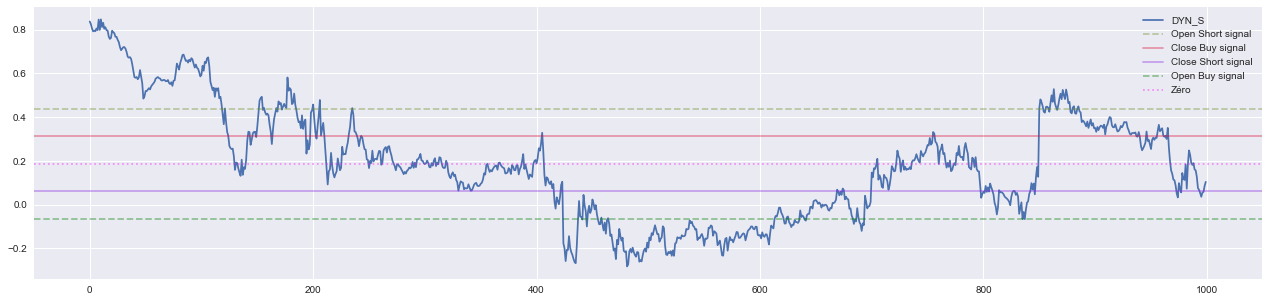

In [5]:
plt.figure(figsize=(22,5))
plt.plot(DYNS,label='DYN_S')
plt.axhline(y=np.array(DYNS).mean()+1*np.array(DYNS).std(),c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal')
plt.axhline(y=np.array(DYNS).mean()+0.5*np.array(DYNS).std(),c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
plt.axhline(y=np.array(DYNS).mean()-0.5*np.array(DYNS).std(),c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
plt.axhline(y=np.array(DYNS).mean()-1*np.array(DYNS).std(),c='green',alpha=0.4,linestyle='--',label='Open Buy signal')
plt.axhline(y=sum(DYNS)/len(DYNS),c='magenta',alpha=0.4,linestyle=':',label='Zéro')
plt.legend()

In [6]:
%%time
navette = mark + 1 
for mark in range(navette,navette+1000):
    dyns()
    test()
    '''if dyn_S < -amplitude or dyn_S > amplitude:
        print('Doo doo again')
        eurusd,audusd,chfusd,gbpusd,jpyusd,PAIR,split,step,S = train(base_eurusd,base_audusd,base_chfusd,base_gbpusd,base_jpyusd,TIME_FRAME)
    else:
        print('test')
        test()'''
#resultats()

   C A L C U L    D E    D Y N _ S  

Le split a été effectué le  2017-03-21 23:10:00 



TAILLES DES POSITIONS :
EUR/USD :  100000
AUD/USD :  -10554.038831339123
CHF/USD :  64150.08785669892
GBP/USD :  22604.152524509092
JPY/USD :  595818.3914296465


Le Score max est :  3.3091004712920498  et le Score min :  -2.008530925272034
 
Indice :  5610 2017-03-27 11:30:00
 
   A C T I O N  
L'amplitude détectée est de  1.0
Voici les 4 limites de short 0.438167359726638 0.5638799823463054 1.0020473420729434
Voici les 4 limites de short -0.1903957533716993 -0.06468313075203183 -0.25507888412373114
Voici la limite de close short 0.06102949186763562
Voici la limite de close long 0.3124547371069705
  Dyn_S :  0.08011383979502545 



  ./\_-°oO-_____T E S T_____-Oo°-_./\ 

 NONE ===> ITERATION SUIVANTE

   C A L C U L    D E    D Y N _ S  

Le split a été effectué le  2017-03-21 23:10:00 



TAILLES DES POSITIONS :
EUR/USD :  100000
AUD/USD :  -10554.038831339123
CHF/USD :  64150.08785669892
GBP/US

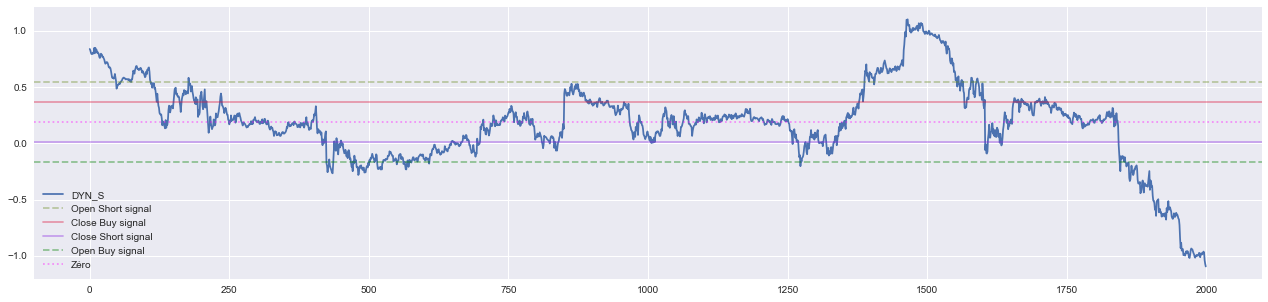

In [7]:
plt.figure(figsize=(22,5))
plt.plot(DYNS,label='DYN_S')
plt.axhline(y=np.array(DYNS).mean()+1*np.array(DYNS).std(),c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal')
plt.axhline(y=np.array(DYNS).mean()+0.5*np.array(DYNS).std(),c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
plt.axhline(y=np.array(DYNS).mean()-0.5*np.array(DYNS).std(),c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
plt.axhline(y=np.array(DYNS).mean()-1*np.array(DYNS).std(),c='green',alpha=0.4,linestyle='--',label='Open Buy signal')
plt.axhline(y=sum(DYNS)/len(DYNS),c='magenta',alpha=0.4,linestyle=':',label='Zéro')
plt.legend()

([<matplotlib.lines.Line2D at 0x1a25353f90>],
 [<matplotlib.lines.Line2D at 0x1a281ea550>])

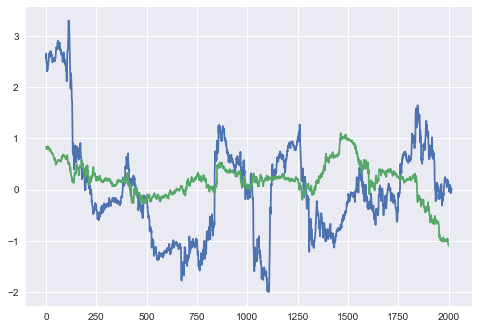

In [11]:
plt.plot(S),plt.plot(DYNS)

 ------------------------------------------------------------------------
 --------------------------------RESULTATS-------------------------------
 ------------------------------------------------------------------------ 
Le profit généré en $  730.93 
Nombre de trades long :  6
Nombre de trades short :  2
Nombre total de trades :  8


()

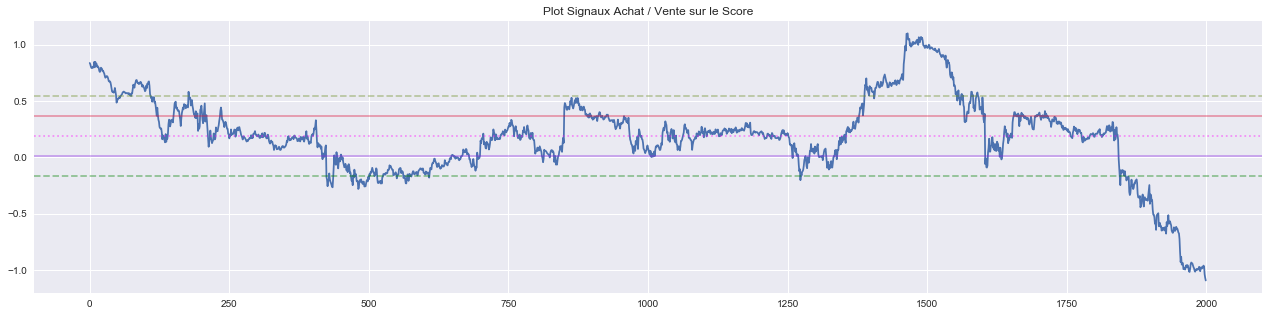

In [9]:
resultats()

In [26]:
amplitude,max(DYNS)-min(DYNS)

(1.0, 0.7150567395523838)